In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.nn import Linear, Softmax, Sigmoid, Module
from scipy.optimize import minimize
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_algorithms.optimizers import COBYLA
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.connectors import TorchConnector
import qiskit
import qiskit_machine_learning
print(qiskit.version.get_version_info())
print(qiskit_machine_learning.version.get_version_info())

1.2.4
0.8.0


In [2]:
# Creating Circuit

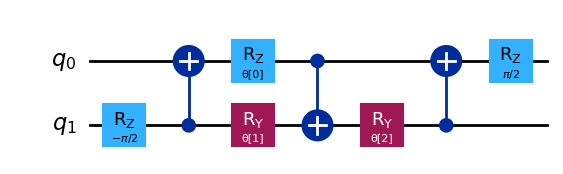

In [3]:
# Two qubit unitary as defined
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target

# Visual
params = ParameterVector("θ", length=3)
circuit = conv_circuit(params)
circuit.draw("mpl")

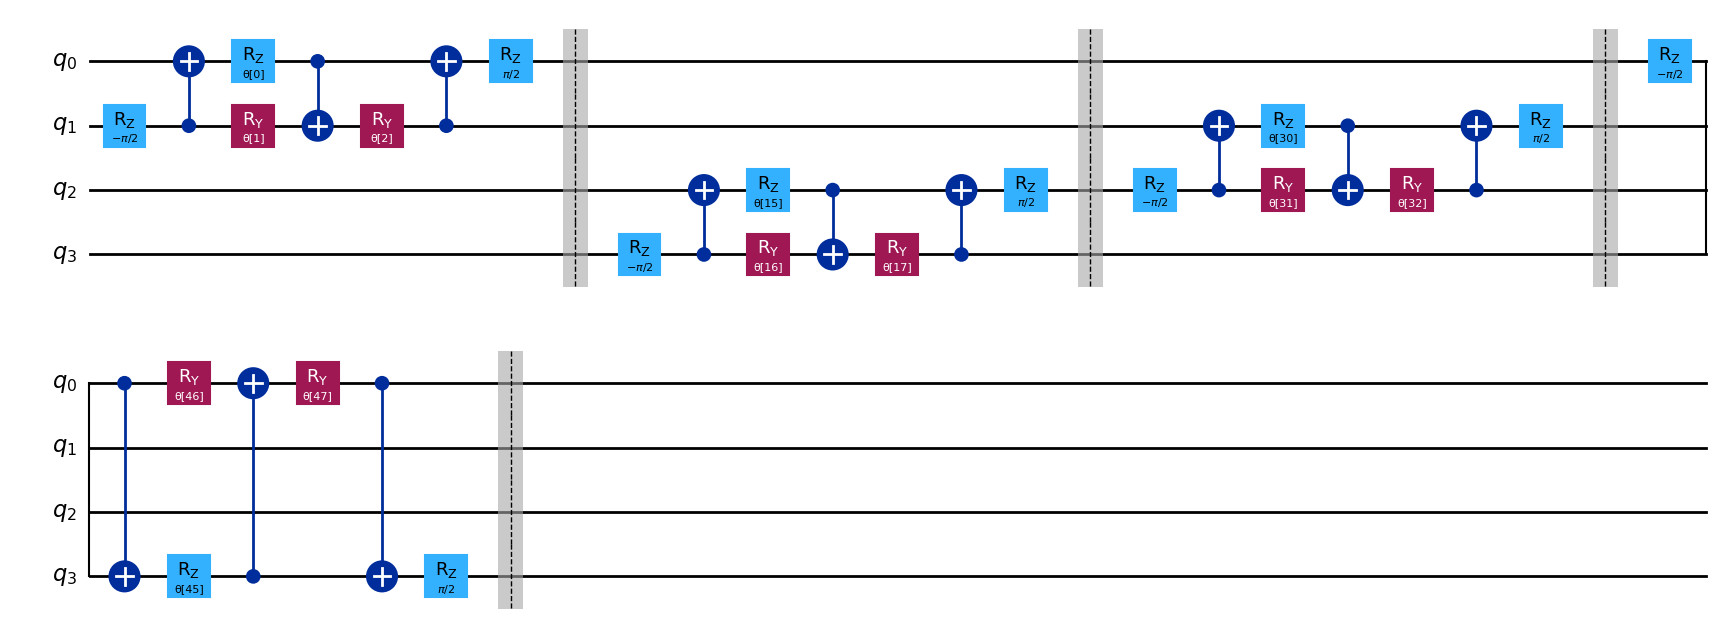

In [4]:
# Create Layer (Repeating Circuit on Neighboring Qubits).
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 15)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 15)]), [q1, q2])
        qc.barrier()
        param_index += 15
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 15)]), [q1, q2])
        qc.barrier()
        param_index += 15

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc

# Visual
circuit = conv_layer(4, "θ")
circuit.decompose().draw("mpl")

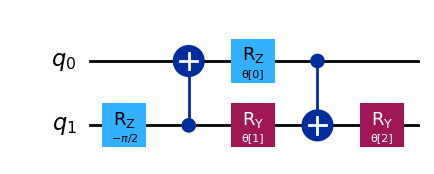

In [5]:
# Defining Pool Circuit
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target

# Visual
params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl")

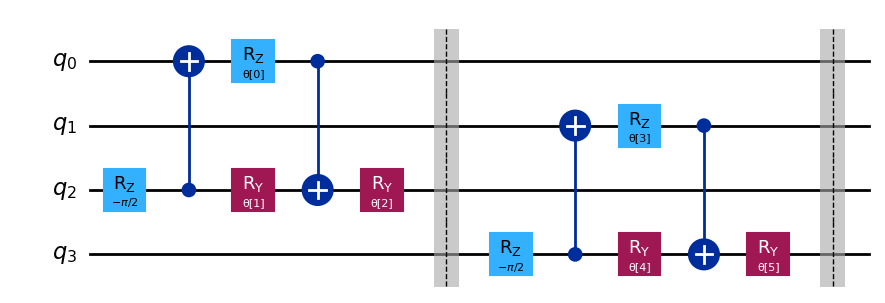

In [6]:
# Defining Pool Layer (Repeating Circuit on Neighboring Qubits)
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc

# Visual
sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl")

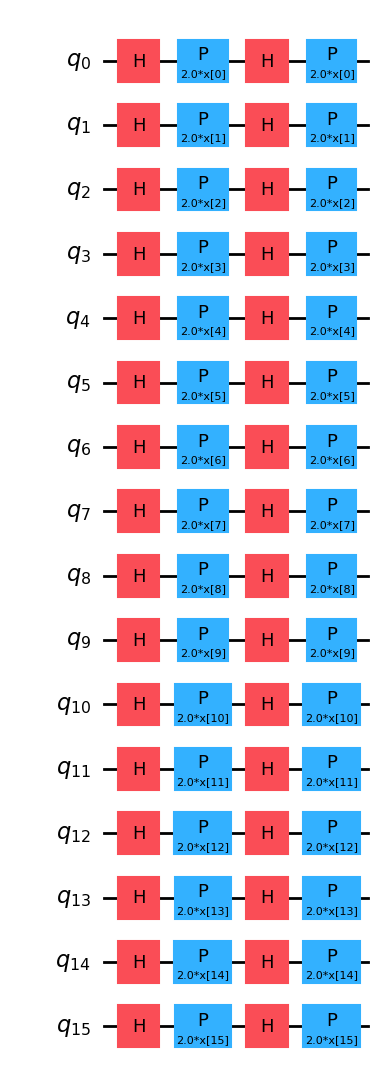

In [7]:
# Feature Map Instantiation
feature_map = ZFeatureMap(16)
feature_map.decompose().draw("mpl")

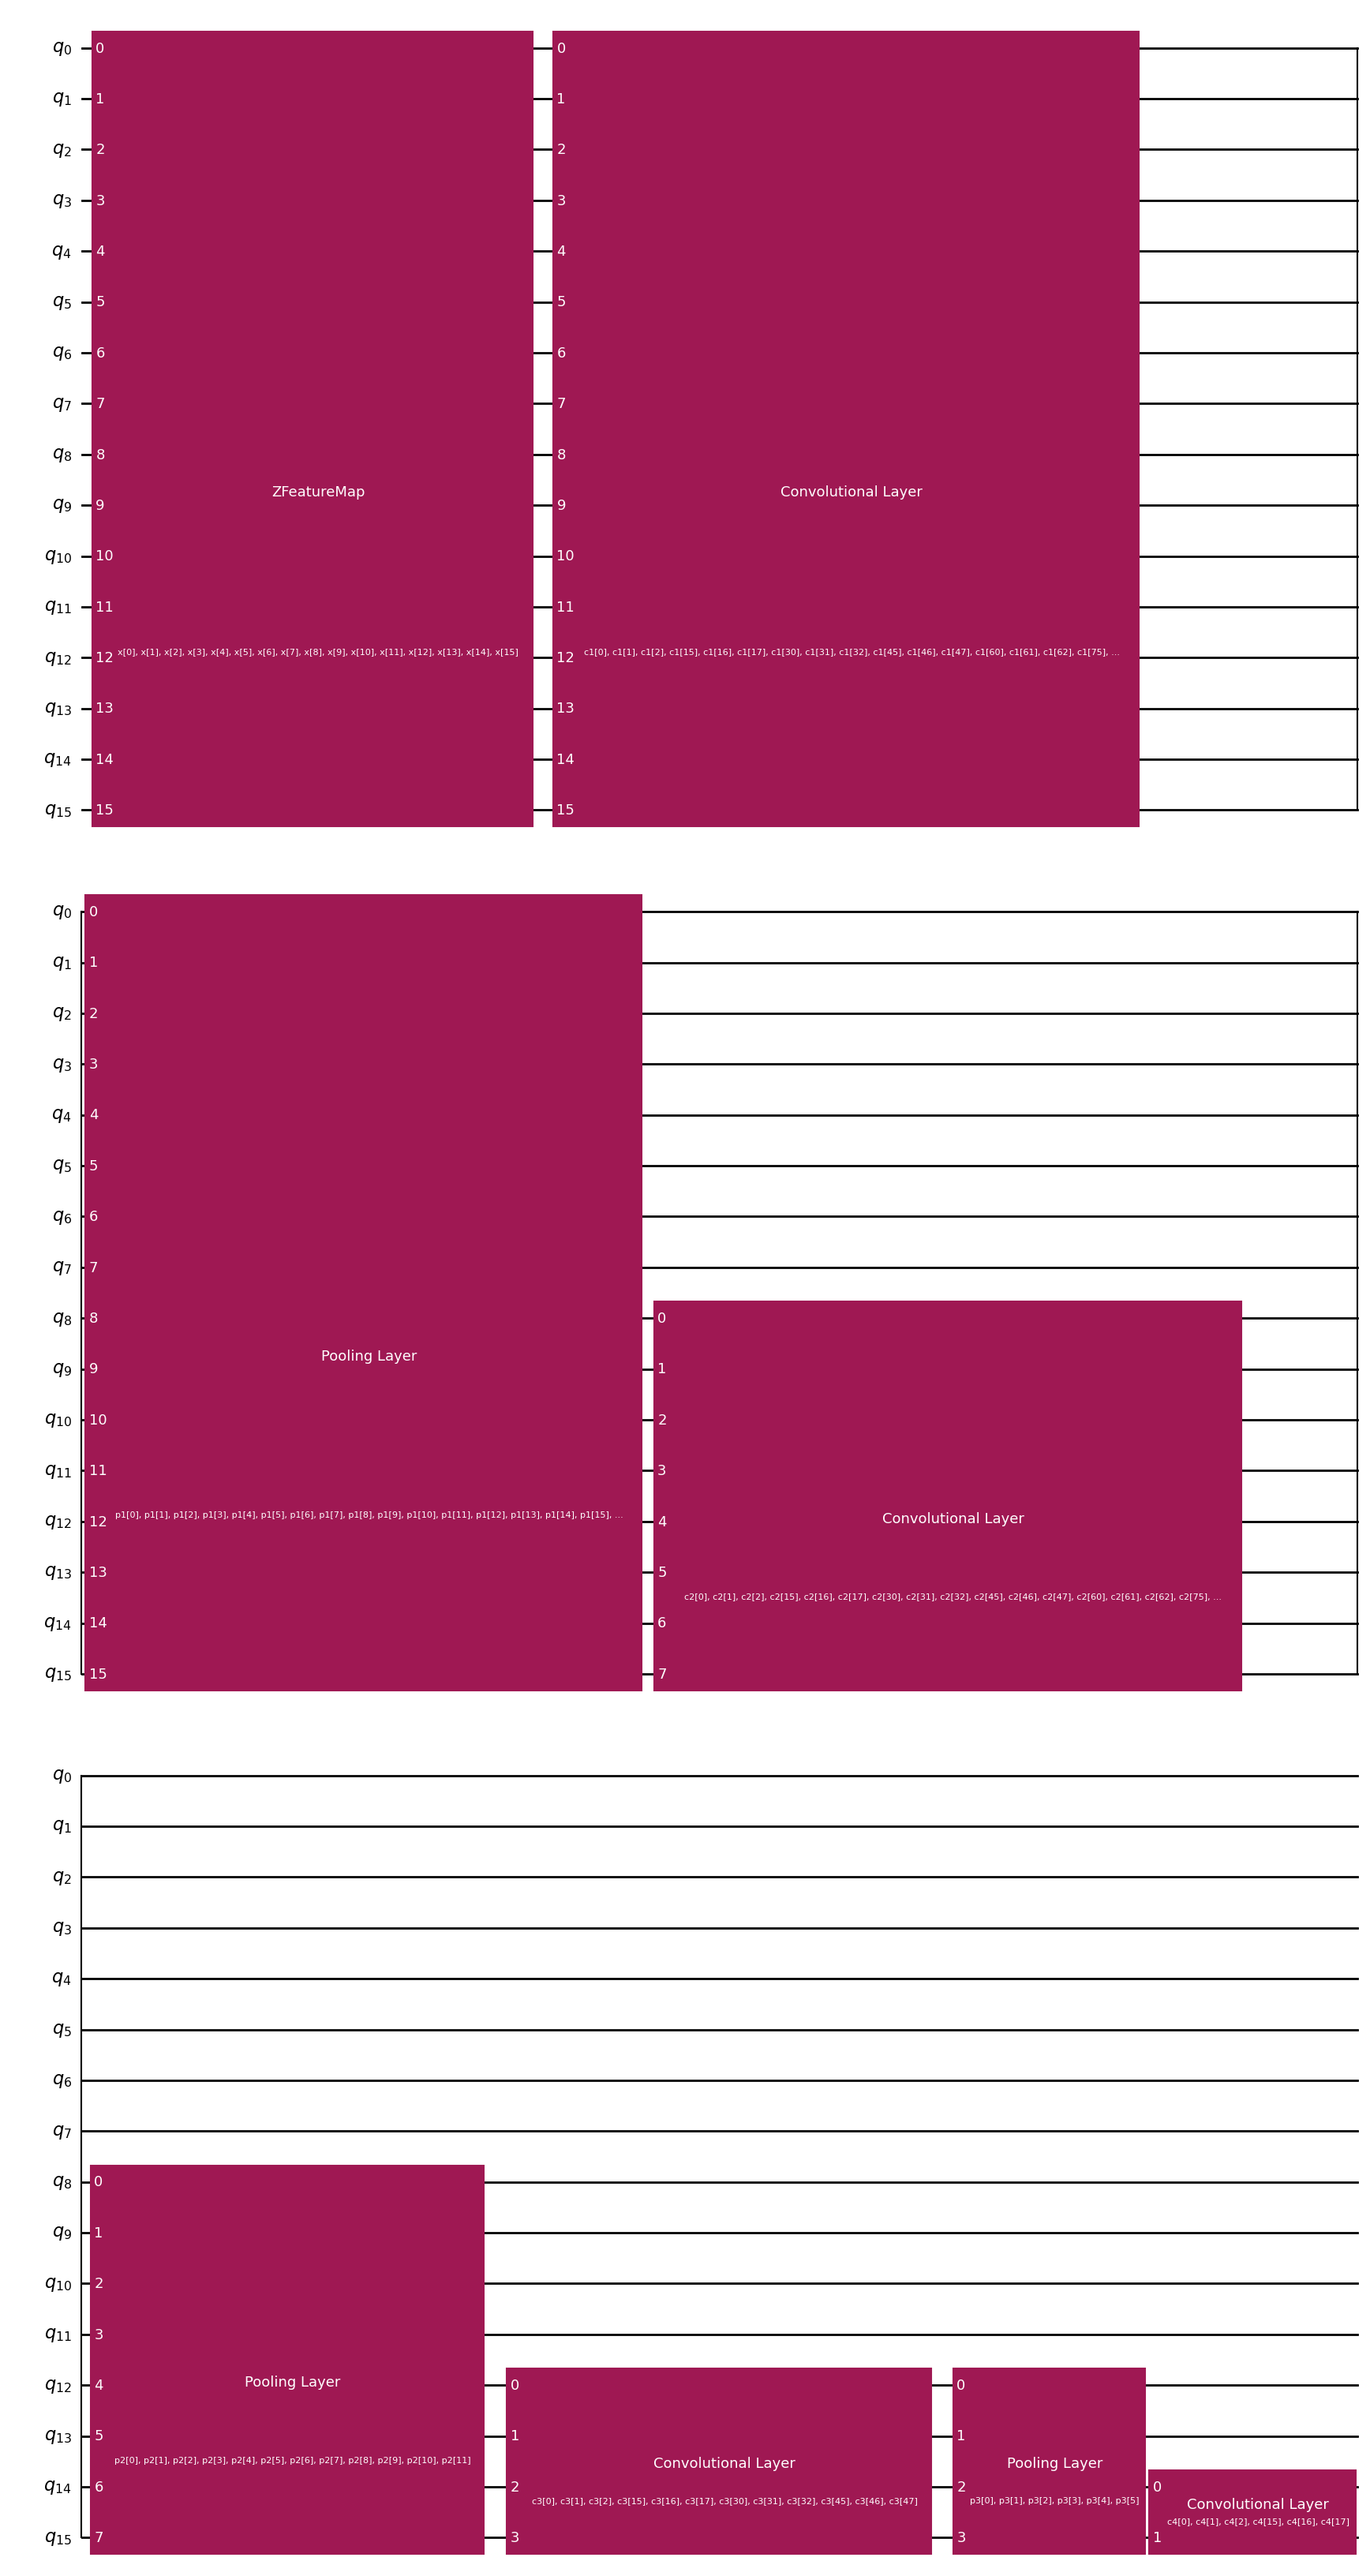

In [8]:
# Ansatz Instantiation Method
from qiskit import ClassicalRegister, QuantumRegister
def create_QCNN():
    q_reg = QuantumRegister(16, "q_reg")
    ansatz = QuantumCircuit(q_reg, name="Ansatz")

    # First Convolutional Layer
    ansatz.compose(conv_layer(16, "с1"), list(range(16)), inplace=True)

    # First Pooling Layer
    ansatz.compose(pool_layer([0, 1, 2, 3, 4, 5, 6, 7], [8, 9, 10, 11, 12, 13, 14, 15], "p1"), list(range(16)), inplace=True)

    # Second Convolutional Layer
    ansatz.compose(conv_layer(8, "c2"), list(range(8, 16)), inplace=True)

    # Second Pooling Layer
    ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p2"), list(range(8, 16)), inplace=True)

    # Third Convolutional Layer
    ansatz.compose(conv_layer(4, "c3"), list(range(12, 16)), inplace=True)

    # Third Pooling Layer
    ansatz.compose(pool_layer([0, 1], [2, 3], "p3"), list(range(12, 16)), inplace=True)

    # Fourth Convolutional Layer
    ansatz.compose(conv_layer(2, "c4"), list(range(14, 16)), inplace=True)

    # Combining the feature map and ansatz
    circuit = QNNCircuit(16)
    circuit.feature_map = feature_map
    circuit.ansatz = ansatz
    return circuit

# Visual
display(create_QCNN().draw("mpl"))

In [9]:
# Creating/Formatting Data

In [10]:
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train[..., np.newaxis]/(255.0/np.pi), x_test[..., np.newaxis]/(255.0/np.pi)
print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

2024-12-14 08:32:05.067451: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734193925.080179   82147 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734193925.084041   82147 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-14 08:32:05.096253: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Number of original training examples: 60000
Number of original test examples: 10000


In [11]:
# Filter Values
a = 3
b = 4
def filter_abcd(x, y):
    keep = (y == a) | (y == b)
    x, y = x[keep], y[keep]
    return x,y

In [12]:
# Filtering using previous method.
x_train, y_train = filter_abcd(x_train, y_train)
x_test, y_test = filter_abcd(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 11973
Number of filtered test examples: 1992


4


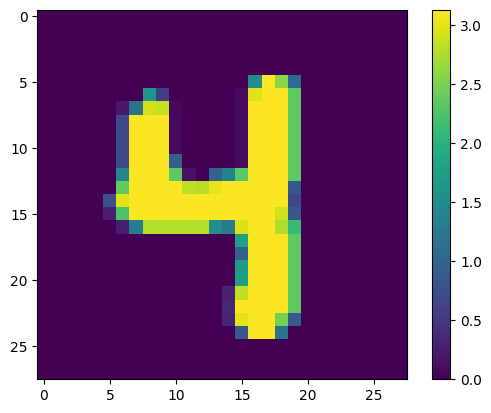

In [13]:
# Displaying Sample Image
img = 13
print(y_train[img])
plt.imshow(x_train[img, :, :, 0])
plt.colorbar()

In [14]:
# Resizing (Quantum Computing Simulation Limit)
x_train_small = tf.image.resize(x_train, (4,4), method = 'area').numpy()
x_test_small = tf.image.resize(x_test, (4,4), method = 'area').numpy()

I0000 00:00:1734193927.623211   82147 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20912 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9


4


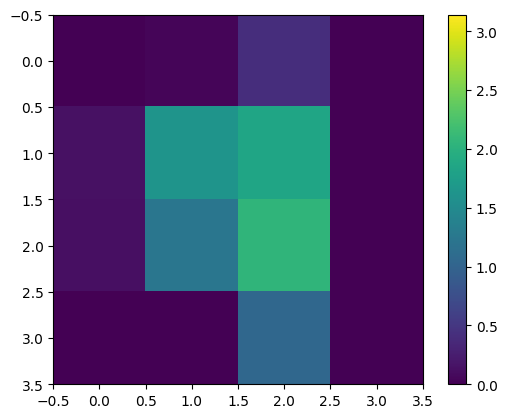

In [15]:
# Displaying Image Sample After Resizing
img = 13
print(y_train[img])
plt.imshow(x_train_small[img,:,:,0], vmin=0, vmax=np.pi)
plt.colorbar()

In [16]:
# Formatting Helper Methods
def format_data(a,b):
    x_reshaped = []
    x1_reshaped = []

    for g in a:
        x_reshaped.append(g.reshape(1,16))

    for g in b:
        x1_reshaped.append(g.reshape(1,16))

    final_x = []
    final_x1 = []

    for entry in x_reshaped:
        final_x.append(entry[0])

    for entry in x1_reshaped:
        final_x1.append(entry[0])
    return final_x, final_x1

def format_labels(y):
    y_temp = []
    for entry in y:
        if entry == a:
            y_temp.append(0)
        elif entry == b:
            y_temp.append(1)
    return y_temp

In [17]:
x,x1 = format_data(x_train_small, x_test_small)

# Easier to work with names
y = y_train
y1 = y_test

# Setting labels to 0,1,2,3 for easy reference later
y = format_labels(y)
y1 = format_labels(y1)

# Converting to nparray
x = np.asarray(x)
y = np.asarray(y)
x1 = np.asarray(x1)
y1 = np.asarray(y1)

# Limiting training dataset to lower training time.
x = x[0:256]
y = y[0:256]
x1 = x1[0:256]
y1 = y1[0:256]
print(x)
print(y)

[[0.0359542  0.         0.04701703 ... 0.         0.54685587 0.        ]
 [0.         0.26902792 0.86968946 ... 1.3765682  0.4684103  0.        ]
 [0.         0.         0.0341942  ... 0.43195325 0.         0.        ]
 ...
 [0.         0.         0.2499194  ... 0.0206171  0.18681097 0.        ]
 [0.         0.09629691 0.17650244 ... 0.32082212 1.137963   0.        ]
 [0.         0.36431915 0.16393104 ... 0.01055997 0.8194038  0.        ]]
[1 0 1 0 0 1 1 0 0 0 0 0 1 1 1 1 1 0 0 1 1 0 0 0 1 1 0 1 0 0 1 1 0 1 0 1 1
 1 0 0 1 0 0 0 0 1 1 0 0 1 0 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 1 0 0 1 0 1 1 0
 1 1 0 0 1 1 1 1 1 1 0 1 0 1 1 1 0 0 1 1 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0
 1 1 0 1 0 1 1 1 1 0 1 0 0 0 1 1 0 1 1 0 0 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1
 0 1 0 0 0 1 1 0 0 1 1 0 1 0 1 1 1 1 1 0 0 0 0 0 0 1 0 1 0 1 0 1 1 1 0 1 1
 1 1 0 0 1 0 0 1 1 1 1 0 0 1 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 1 1 0 1 0 0 0 1
 0 0 1 0 0 0 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 0 1 0 1 1 0 0 0 0 1 1 1]


In [18]:
# Additional Helper Functions
def count(y):
    counta = 0
    countb = 0
    for i in range(len(y)):
        if y[i] == 0:
            counta+=1
        elif y[i] == 1:
            countb+=1
    return(counta, countb)

def balance_lists(x, y, max_count):
    """Balances two lists x and y based on the values in y (0 or 1)."""
    
    x_balanced = []
    y_balanced = []
    count0 = 0
    count1 = 0

    for i in range(len(y)):
        if y[i] == 0:
            if count0 < max_count:
                x_balanced.append(x[i])
                y_balanced.append(y[i])
                count0 += 1
        elif y[i] == 1:
            if count1 < max_count:
                x_balanced.append(x[i])
                y_balanced.append(y[i])
                count1 += 1
    return x_balanced, y_balanced

def shuffle(arr1, arr2):
    assert len(arr1) == len(arr2)
    p = np.random.permutation(len(arr1))
    return arr1[p], arr2[p]

In [19]:
# Further Data Cleaning Using Helper Functions
nums = count(y)
print("original:", nums)
max_count = min(nums)
print("max_count =", max_count)
x,y = balance_lists(x, y, max_count)

print("balanced:", count(y))

# Converting to nparray
x = np.asarray(x)
y = np.asarray(y)
x1 = np.asarray(x1)
y1 = np.asarray(y1)
objective_func_vals = []

x,y = shuffle(x,y)
print("shuffled:", count(y))

print("final:", x)
print(y)

original: (118, 138)
max_count = 118
balanced: (118, 118)
shuffled: (118, 118)
final: [[0.         0.4070619  0.03369135 ... 0.9096664  0.49279886 0.        ]
 [0.         0.01382854 0.34495917 ... 0.9375749  0.02313137 0.        ]
 [0.         0.40228474 1.0326148  ... 1.2292314  0.33012494 0.        ]
 ...
 [0.         0.3354049  0.         ... 0.40329048 0.46539322 0.        ]
 [0.33138204 0.         0.06863984 ... 0.         0.20541665 0.29417074]
 [0.         0.24036516 0.         ... 0.         0.5224674  0.        ]]
[0 1 0 1 1 0 0 0 1 0 0 1 0 0 1 0 0 1 1 1 0 0 0 1 0 0 1 0 1 0 0 1 0 1 1 0 0
 1 0 0 0 0 0 1 1 1 1 0 0 1 0 0 1 0 0 1 0 0 1 1 0 1 1 0 0 1 1 1 1 0 1 1 1 1
 0 0 0 1 1 0 1 1 1 0 1 0 0 0 0 1 1 0 0 0 1 1 1 0 1 0 0 1 1 0 0 1 1 0 0 0 1
 1 1 1 1 1 1 0 0 0 1 1 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 1 0 1 0 0 1 0
 0 1 0 0 1 1 0 1 1 1 1 1 0 1 1 0 1 0 0 0 1 1 1 1 1 0 0 0 0 1 0 1 1 0 0 1 1
 0 1 1 0 1 0 0 1 1 1 1 0 1 1 1 1 0 1 0 0 1 1 0 1 0 0 1 0 1 1 1 0 0 1 0 0 1
 1 1 0 1 0 0 0 0 0 1

In [20]:
# Tensor for Pytorch
X = torch.tensor(x, dtype=torch.float32).to("cuda")
Y = torch.tensor(y, dtype=torch.long).to("cuda")
X1 = torch.tensor(x1, dtype=torch.float32).to("cuda")
Y1 = torch.tensor(y1, dtype=torch.long).to("cuda")

In [21]:
# One-Hot Encoding for Final Processing
num_classes = 2
Y = (torch.nn.functional.one_hot(Y, num_classes=num_classes).float())
Y1 = (torch.nn.functional.one_hot(Y1, num_classes=num_classes).float())

In [22]:
print(X,Y,X1,Y1)

tensor([[0.0000, 0.4071, 0.0337,  ..., 0.9097, 0.4928, 0.0000],
        [0.0000, 0.0138, 0.3450,  ..., 0.9376, 0.0231, 0.0000],
        [0.0000, 0.4023, 1.0326,  ..., 1.2292, 0.3301, 0.0000],
        ...,
        [0.0000, 0.3354, 0.0000,  ..., 0.4033, 0.4654, 0.0000],
        [0.3314, 0.0000, 0.0686,  ..., 0.0000, 0.2054, 0.2942],
        [0.0000, 0.2404, 0.0000,  ..., 0.0000, 0.5225, 0.0000]],
       device='cuda:0') tensor([[1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
  

In [23]:
# Training

In [24]:
# Pytorch Circuit Module
import torch.nn as nn
class Model(Module): # Simplified
    def __init__(self, qnn_module):
        super().__init__()
        self.qnn_module = qnn_module
        self.softmax = nn.Softmax(dim = -1)

    def forward(self, x):
        x = self.qnn_module(x)
        x = self.softmax(x)
        return x

In [25]:
from qiskit_aer.primitives import Estimator
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.utils import algorithm_globals

# Reproducable seeds
num_qubits = 16
algorithm_globals.random_seed = 65
seed = 90

# Creating GPU compatible Estimator primitive
sampler = Estimator()
sampler.set_options(device='GPU')
sampler.set_options(method="statevector")
sampler.set_options(seed = seed)

# Setting observables on 15th and 16th qubits.
observable_z15 = SparsePauliOp.from_sparse_list([("Z", [14], 1)], num_qubits=num_qubits)
observable_z16 = SparsePauliOp.from_sparse_list([("Z", [15], 1)], num_qubits=num_qubits)
observables = [observable_z15, observable_z16]

# Instantiating underlying EstimatorQNN
estimator = EstimatorQNN(
    estimator = sampler,
    circuit = create_QCNN(),
    observables = observables,
)

# Initial Forward Weights
weights = algorithm_globals.random.random(estimator.num_weights)

# Checking Data Forward Result
estimator.forward(input_data = x1[:30], weights = weights)

/tmp/ipykernel_82147/169549018.py:22: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  estimator = EstimatorQNN(
/tmp/ipykernel_82147/169549018.py:22: UserWarning: No number of qubits was not specified (None) and was retrieved from `circuit` (16). If `circuit` is transpiled, this may cause unstable behaviour.
  estimator = EstimatorQNN(


array([[ 0.07226562, -0.07421875],
       [ 0.08789062, -0.00195312],
       [ 0.125     ,  0.        ],
       [ 0.12109375, -0.03710938],
       [ 0.13867188, -0.05664062],
       [ 0.14453125, -0.01757812],
       [ 0.09179688, -0.09179688],
       [ 0.0546875 , -0.07421875],
       [ 0.1484375 , -0.015625  ],
       [ 0.07421875, -0.09179688],
       [ 0.109375  , -0.08984375],
       [-0.03320312,  0.03710938],
       [ 0.11523438, -0.0625    ],
       [ 0.046875  , -0.00585938],
       [ 0.04101562, -0.02148438],
       [ 0.11328125, -0.06054688],
       [ 0.12890625,  0.015625  ],
       [ 0.11328125, -0.00585938],
       [-0.00976562, -0.0859375 ],
       [ 0.16210938, -0.04492188],
       [ 0.05273438,  0.00195312],
       [ 0.0078125 , -0.01367188],
       [ 0.04492188, -0.08984375],
       [-0.01171875, -0.10742188],
       [-0.03515625, -0.04296875],
       [ 0.06054688, -0.05664062],
       [ 0.09375   , -0.05078125],
       [ 0.1015625 , -0.12304688],
       [ 0.12890625,

In [26]:
# Wrapping estimator with initial weights under TorchConnecter, itself under Pytorch Module.
model = Model(TorchConnector(estimator, weights))
model.to("cuda")
next(model.parameters()).is_cuda

True

In [27]:
model(X[:30])

tensor([[0.5288, 0.4712],
        [0.5005, 0.4995],
        [0.5263, 0.4737],
        [0.5438, 0.4562],
        [0.5453, 0.4547],
        [0.5366, 0.4634],
        [0.5463, 0.4537],
        [0.5356, 0.4644],
        [0.5327, 0.4673],
        [0.5361, 0.4639],
        [0.5482, 0.4518],
        [0.4937, 0.5063],
        [0.5550, 0.4450],
        [0.5195, 0.4805],
        [0.5220, 0.4780],
        [0.5312, 0.4688],
        [0.5063, 0.4937],
        [0.5390, 0.4610],
        [0.5302, 0.4698],
        [0.5545, 0.4455],
        [0.5103, 0.4897],
        [0.5103, 0.4897],
        [0.5283, 0.4717],
        [0.5433, 0.4567],
        [0.5288, 0.4712],
        [0.5259, 0.4741],
        [0.5419, 0.4581],
        [0.5322, 0.4678],
        [0.5351, 0.4649],
        [0.5000, 0.5000]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [28]:
# Callback Helper Functions
loss_func = tf.keras.losses.CategoricalCrossentropy()

def accuracy(output, Y):
    acc = 0
    for i in range(Y.size(dim=0)):
        val = output[i]
        if (torch.argmax(val) == torch.argmax(Y[i])):
            acc+=1
    return ((acc/(Y.size(dim=0)))*100)

def objective_function(weights):
    global X
    global Y
    if(i != 1 and i%333 == 0):
        indices = torch.randperm(X.size()[0])
        X=X[indices]
        Y=Y[indices]
        print(X,Y)
    # Referencing Global Variables
    global data
    # Local Variable
    total_loss = 0.0
    # Overiding with new data
    model = Model(TorchConnector(estimator, weights)).to("cuda")
    # Getting Output
    output = model(X)
    loss_output = output.detach().cpu().numpy()
    loss_Y = Y.detach().cpu().numpy()
    # Calculate Loss
    loss = loss_func(loss_output, loss_Y).numpy()
    # Append Checkpoint Data Points to Tracker
    val = f"Iteration: {i}; Accuracy: {accuracy(output, Y)}%; Loss: {loss}"
    data.append(val)
    total_loss += loss
    loss_list.append(total_loss)
    return total_loss

def callback(weights):
    # Iteration Tracking
    global i
    global weight_list
    # Printing Checkpoint Data Points in Tracker
    print("\n".join(data))
    # Plotting Loss Function
    plt.title("Loss value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Loss function value")
    plt.plot(range(len(loss_list)), loss_list)
    plt.show()
    # Printing Weights
    weight_list.append(weights)
    print(weights)
    # Iteration Counter
    i+=1
    # Clearing Previous Graph/Weights
    clear_output(wait=True)

In [29]:
# Training Function
def fit(weights=None, losslist=None, iter= 1000, fresh_start = False):
    global i
    global data
    global weight_list
    global loss_list
    if(fresh_start):
        loss_list = []
        data = []
        weight_list = []
        weights = algorithm_globals.random.random(estimator.num_weights)
        i = 1
    else:
        if 'data' not in globals(): data = []
        else: data = data
        if 'weight_list' not in globals():weight_list = []
        else: weight_list = weight_list
        if 'i' not in globals() and 'i' not in locals(): i = 1
        else: i = i
        if losslist is not None: losslist = losslist
        elif (('loss_list' not in globals() and 'loss_list' not in locals()) and losslist == None): loss_list = []
        elif 'loss_list' not in globals() and 'loss_list' not in locals(): loss_list = losslist
        else: loss_list = loss_list
        if weights is not None: weights = weights
        elif (len(weight_list)>0):
            weights = weight_list[-1]
        elif (('result' not in locals() and 'result' not in globals())) and weights == None:
            weights = algorithm_globals.random.random(estimator.num_weights)
        else:
            weights = result[0].x
            loss_list = result[2]
    
    result = minimize(
        fun=objective_function,
        callback = callback,
        x0=weights,
        method='COBYLA',
        options={'maxiter': iter},
    )
    return result, data, loss_list, weight_list

Iteration: 1; Accuracy: 43.22033898305085%; Loss: 8.126280784606934
Iteration: 2; Accuracy: 38.13559322033898%; Loss: 8.125556945800781
Iteration: 3; Accuracy: 40.25423728813559%; Loss: 8.127607345581055
Iteration: 4; Accuracy: 40.67796610169492%; Loss: 8.117658615112305
Iteration: 5; Accuracy: 43.22033898305085%; Loss: 8.110054969787598
Iteration: 6; Accuracy: 45.76271186440678%; Loss: 8.10558795928955
Iteration: 7; Accuracy: 45.76271186440678%; Loss: 8.106122016906738
Iteration: 8; Accuracy: 47.45762711864407%; Loss: 8.098064422607422
Iteration: 9; Accuracy: 50.42372881355932%; Loss: 8.075066566467285
Iteration: 10; Accuracy: 45.76271186440678%; Loss: 8.082464218139648
Iteration: 11; Accuracy: 41.94915254237288%; Loss: 8.11775016784668
Iteration: 12; Accuracy: 53.813559322033896%; Loss: 8.046745300292969
Iteration: 13; Accuracy: 56.779661016949156%; Loss: 8.040414810180664
Iteration: 14; Accuracy: 59.7457627118644%; Loss: 8.00479793548584
Iteration: 15; Accuracy: 52.118644067796616%;

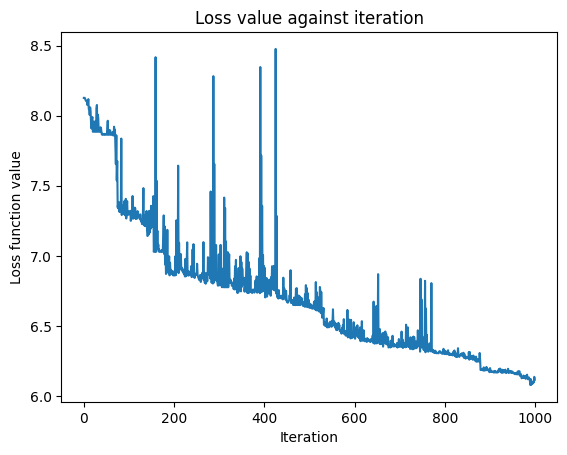

[ 1.50604857  0.23616992  1.0807128   1.44800589  1.22570138  0.96413187
  1.50872729  1.10056588  0.87136691  0.34108386  0.45652376  2.06682449
  1.86244464  1.53834858  0.36974342  1.184755    1.8873731   0.37212764
  0.83686313  1.23761715  0.11172773 -0.33567612  0.25261283  0.33233887
  0.40898488 -0.12444661  0.79970495  1.2007283   1.40196207  0.50056457
  0.26610085  0.70609972  0.89958815 -0.17966942  0.52356372  0.75084435
  0.31489071  0.89327661  0.72550031  0.34909415  1.46442006  0.74472919
  1.16232499  0.26331931  0.01860304  0.35242694  1.09411258  1.93317163
  0.43786173  1.4383705   0.65746932  0.20250495  0.53067128  0.84234115
  0.92253029  0.38656834  0.87677938  0.2064618   0.01679925  0.57647033
  0.22164784  0.65801049  0.55827455  1.15378106  1.41374569 -0.25760203
 -0.00328102  0.13316063  0.87949497  1.89941039  1.58966135  0.06243143
  1.63810466  0.040584    1.51150582  0.67405933  1.77410922  0.6896855
  1.4150698   0.53207556  1.80995378  0.45289566  0.

In [30]:
%time
# Call Training Function and Save as Result
result = fit(iter=1000, fresh_start=False)

In [31]:
savemodel = Model(TorchConnector(estimator, result[0].x))
print(next(model.parameters()).is_cuda)
torch.save(savemodel, "TwoQubits(One_Hot)")

True


In [32]:
evalmodel = torch.load("TwoQubits(One_Hot)", weights_only=False).to("cuda")
evalmodel.eval()
output0 = evalmodel(X)
output1 = evalmodel(X1)
print(f"Train Accuracy: {accuracy(output0, Y)}%")
print(f"Test Accuracy: {accuracy(output1, Y1)}%")

Train Accuracy: 77.11864406779661%
Test Accuracy: 72.65625%


In [33]:
def translate(array):
    arr = []
    for e in array:
        arr.append(torch.argmax(e))
    return arr
print(f"output 0: {translate(output0)}, \n Y:       {translate(Y)}, \n output 1: {translate(output1)}, \n Y1:       {translate(Y1)}")

output 0: [tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1,

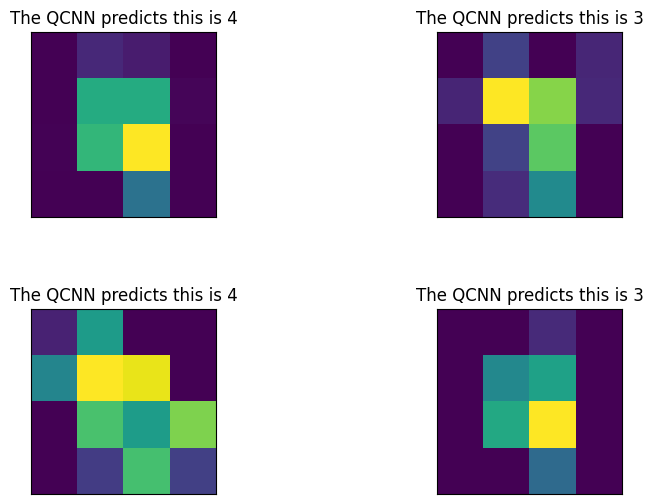

In [34]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(0, 4):
    ax[i // 2, i % 2].imshow(X1.detach().cpu().numpy()[i].reshape(4, 4), aspect="equal")
    if torch.argmax(output0[i]) == 0:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is 3")
    if torch.argmax(output0[i]) == 1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is 4")
plt.subplots_adjust(wspace=0.1, hspace=0.5)

In [35]:
print(result)

( message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: 6.079126358032227
       x: [ 1.506e+00  2.362e-01 ...  2.688e-01  4.954e-01]
    nfev: 1000
   maxcv: 0.0, ['Iteration: 1; Accuracy: 43.22033898305085%; Loss: 8.126280784606934', 'Iteration: 2; Accuracy: 38.13559322033898%; Loss: 8.125556945800781', 'Iteration: 3; Accuracy: 40.25423728813559%; Loss: 8.127607345581055', 'Iteration: 4; Accuracy: 40.67796610169492%; Loss: 8.117658615112305', 'Iteration: 5; Accuracy: 43.22033898305085%; Loss: 8.110054969787598', 'Iteration: 6; Accuracy: 45.76271186440678%; Loss: 8.10558795928955', 'Iteration: 7; Accuracy: 45.76271186440678%; Loss: 8.106122016906738', 'Iteration: 8; Accuracy: 47.45762711864407%; Loss: 8.098064422607422', 'Iteration: 9; Accuracy: 50.42372881355932%; Loss: 8.075066566467285', 'Iteration: 10; Accuracy: 45.76271186440678%; Loss: 8.082464218139648', 'Iteration: 11; Accuracy: 41.94915254237288%; Loss: 8.11775016784668', 'It

In [36]:
result[1]

['Iteration: 1; Accuracy: 43.22033898305085%; Loss: 8.126280784606934',
 'Iteration: 2; Accuracy: 38.13559322033898%; Loss: 8.125556945800781',
 'Iteration: 3; Accuracy: 40.25423728813559%; Loss: 8.127607345581055',
 'Iteration: 4; Accuracy: 40.67796610169492%; Loss: 8.117658615112305',
 'Iteration: 5; Accuracy: 43.22033898305085%; Loss: 8.110054969787598',
 'Iteration: 6; Accuracy: 45.76271186440678%; Loss: 8.10558795928955',
 'Iteration: 7; Accuracy: 45.76271186440678%; Loss: 8.106122016906738',
 'Iteration: 8; Accuracy: 47.45762711864407%; Loss: 8.098064422607422',
 'Iteration: 9; Accuracy: 50.42372881355932%; Loss: 8.075066566467285',
 'Iteration: 10; Accuracy: 45.76271186440678%; Loss: 8.082464218139648',
 'Iteration: 11; Accuracy: 41.94915254237288%; Loss: 8.11775016784668',
 'Iteration: 12; Accuracy: 53.813559322033896%; Loss: 8.046745300292969',
 'Iteration: 13; Accuracy: 56.779661016949156%; Loss: 8.040414810180664',
 'Iteration: 14; Accuracy: 59.7457627118644%; Loss: 8.004797